In [1]:
# %matplotlib widget
import os
import numpy as np
import h5py

repetitions = 10
tissue_type = 0 # 0 = extra-vascular, 1 = intra-vascular, [0,1] = combined
oxy_level = [78, 85]
results_dir = './outputs'

def read_results(filename):
    signal_magnitude = []
    for rep in range(repetitions):        
        filepath = os.path.join(results_dir, f'{filename}_rep{rep+1}.h5')
        with h5py.File(filepath, 'r') as h5:
            M = np.array(h5['M'])
            T = np.array(h5['T'])                
            S = np.array(h5['scales'])  
        
            mask = (T[0, :, 0, 0] == tissue_type)
            M = M[0, mask, 0, :]
            M = np.sum(M[:,0:2], axis=0)
            signal_magnitude.append(np.linalg.norm(M))            
    return signal_magnitude


############
radii = [1, 2, 5, 8, 12 ,20, 35, 50, 75]
signal_change = []
for idr, r in enumerate(radii):
    signal_magnitude = []
    for o in oxy_level:
        filename = f'gre_{o}_r{r}_Y0.0_BVF4_ori90_fov1000_res1000'
        signal_magnitude.append(read_results(filename))
    signal_magnitude = np.array(signal_magnitude)
    signal_change.append(100 * (1 - signal_magnitude[0,:] / signal_magnitude[1,:]))


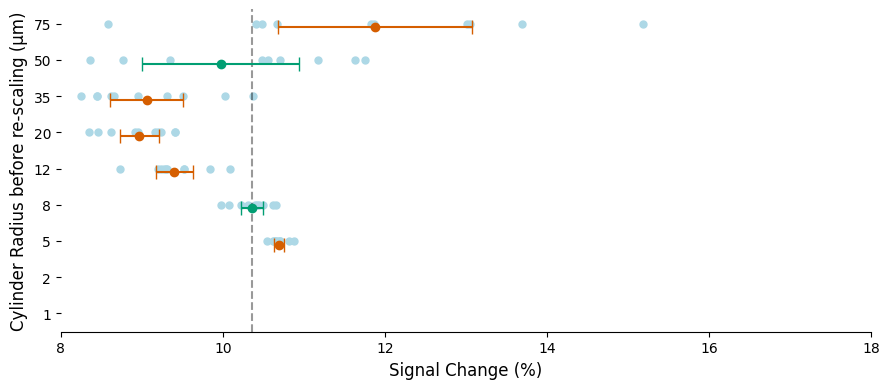

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none' # to embed fonts in SVG output

def plot_results(ax, signal_change, sample_size, true_mean=None, y_label='Radius (um)', fontsize=12):
    # Parameters
    num_samples = len(signal_change)
    sample_size = 10
    ci_level = 1.96  # 95% confidence interval for normal distribution

    sample_means   = [np.mean(sig) for sig in signal_change]
    sample_stds    = [np.std(sig, ddof=1) for sig in signal_change]
    conf_intervals = [(mean - ci_level * std / np.sqrt(sample_size), mean + ci_level * std / np.sqrt(sample_size))
                      for mean, std in zip(sample_means, sample_stds)]
    if true_mean is None:
        true_mean = np.mean(sample_means[3])

    # Plot population mean
    ax.axvline(x=true_mean, color='black', linestyle='--', label='True Mean', alpha=0.4)
    # Plot samples and their confidence intervals
    for i, (mean, (ci_low, ci_high)) in enumerate(zip(sample_means, conf_intervals)):
        color = '#019e73' if ci_low <= true_mean <= ci_high else '#d55e00'
        ax.errorbar(mean, i-0.1, xerr=[[mean - ci_low], [ci_high - mean]], fmt='o', color=color, capsize=5)
        ax.scatter(signal_change[i], [i] * sample_size, color='#add8e6', s=25)

    # Labels and title
    # ax.set_yticks(range(1, num_samples + 1))
    # ax.set_yticklabels(range(1, num_samples + 1))
    ax.set_xlabel('Signal Change (%)', fontsize=fontsize)
    ax.set_ylabel(y_label, fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.patch.set_visible(False)
    # ax.yaxis.grid(True, linewidth=0.7, color='#e5e5e5')
    return true_mean

# Plotting
plt.close('all')
fig = plt.figure(figsize=(9, 4))
gs  = fig.add_gridspec(10,10)

ax1 = fig.add_subplot(gs[:, :])
true_mean = plot_results(ax1, signal_change, repetitions, y_label='Cylinder Radius before re-scaling (µm)')
y_ticks = np.arange(0, len(signal_change), 1)
y_labels = [f'{r}' for r in radii]
ax1.set_yticks(ticks=y_ticks, labels=y_labels)
ax1.set_xlim(8, 18)
# ax1.text(-0.07, 0.98, '(A)', transform=ax1.transAxes, fontsize=12, weight='bold')
fig.tight_layout()
plt.savefig(f'../figures_pdf/uncertainty_1.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()